!pip install pandas-datareader

!pip install PyPortfolioOpt

!pip install plotly

!pip install seaborn

In [1]:
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

from pandas_datareader.data import DataReader
import yfinance as yf
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import plotting
import copy
import numpy as np
import pandas as pd

## Get Stock Prices using pandas_datareader Library
Let's get some data for the stock tickers that we want to include in our portfolio. The pandas-datareader library provides a method to pull stock price data from the web and store it in a DataFrame. 

If you do not pass in the start and end dates, stock prices will be given for the full date range available. Note that the date range may be different for different stocks depending on when they were listed.

In [10]:
start_date = '2018-05-18' 
end_date = '2023-12-27'

stocks_df = pd.read_csv('res.csv', index_col=False)
stocks_df['Date'] = pd.to_datetime(stocks_df['Date'], format='%Y-%m-%d')
stocks_df = stocks_df.set_index('Date')
tickers = stocks_df.columns.tolist()
print(tickers)
stocks_df.head()

['HDB', 'MBB', 'JVC', 'ACB', 'VND', 'PVT', 'ITA', 'AAA', 'TPB', 'HAH', 'VHM', 'VNM', 'VHC', 'PNJ', 'BVH', 'GAS', 'BCM', 'FRT', 'SAB', 'DHG', 'VIC', 'VJC', 'MSN', 'SLS', 'RAL']


HDB      MBB     JVC      ACB      VND      PVT     ITA  \
Date                                                                      
2018-05-18  15172.8  12206.9  3470.0  14094.2  20741.3  18300.0  2250.0   
2018-05-21  15378.6  11924.9  3470.0  13896.6  20042.2  18000.0  2260.0   
2018-05-22  14592.9  11602.6  3350.0  13534.3  18643.9  17800.0  2230.0   
2018-05-23  14106.4  11804.1  3430.0  13666.1  19948.9  18500.0  2200.0   
2018-05-24  13283.2  11783.9  3350.0  13501.4  19110.0  18150.0  2180.0   

                AAA      TPB      HAH  ...       GAS      BCM      FRT  \
Date                                   ...                               
2018-05-18  15065.7  14054.7  14200.0  ...  115000.0  22200.0  51195.3   
2018-05-21  14869.6  13983.7  14200.0  ...  108500.0  22000.0  50104.0   
2018-05-22  14398.8  13865.4  13900.0  ...  105900.0  22000.0  50104.0   
2018-05-23  15379.6  13912.8  13950.0  ...  113300.0  25500.0  50392.9   
2018-05-24  16007.4  13865.4  14000.0  ...  113200.0  25500.0  51073.4   

                 SAB       DHG       VIC       VJC      MSN      SLS       RAL  
Date                                                                            
2018-05-18  252400.0  103000.0  101653.0  158333.0  92500.0  64100.0  113900.0  
2018-05-21  251000.0  103500.0   94545.0  153333.0  89000.0  63000.0  113900.0  
2018-05-22  247900.0  102000.0   87934.0  147417.0  85000.0  62000.0  113800.0  
2018-05-23  243000.0  103000.0   85124.0  148333.0  85000.0  63900.0  115000.0  
2018-05-24  242800.0  101000.0   86033.0  142917.0  84500.0  64500.0  115000.0  

[5 rows x 25 columns]

## Plot Individual Stock Prices
The graph is plotted with plotly library. It is an interactive graph.

/home/son/anaconda3/lib/python3.11/site-packages/_plotly_utils/basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



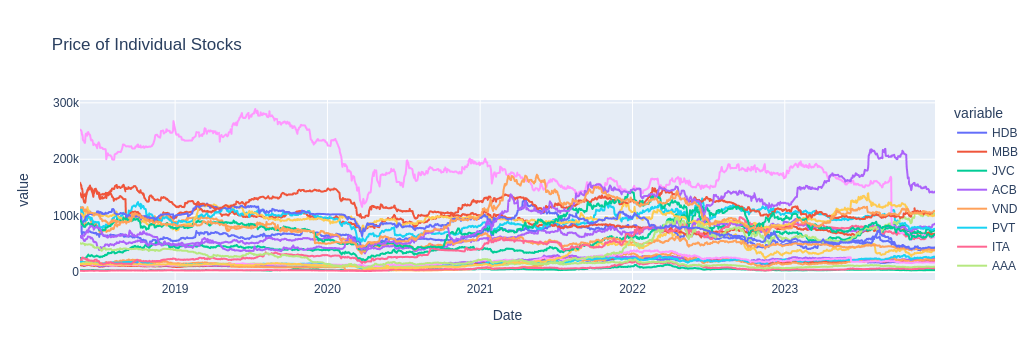

In [11]:
fig_price = px.line(stocks_df, title='Price of Individual Stocks')
fig_price.show()

As seen above, Amazon seems to dominate the scale of the graph as the absolute price of the stock is very high. The graphs of all other stocks are flattened out. A graph like this is not very useful to compare the relative performance of the stocks. To address this, let's see how we can better measure the performance of a stock by exploring the concepts of daily returns and volatility.

## Daily Returns
The daily returns of a stock is the fractional gain (or loss) on a given day relative to the previous day, it is given by (current day's close price - previous day's close price) / (previous day's close price). As it is a relative value, it provides a fairer comparison between stock returns regardless of absolute stock prices. The pct_change() method can be used to get the daily returns efficiently.

In [12]:
daily_returns = stocks_df.pct_change().dropna()
daily_returns.head()

HDB       MBB       JVC       ACB       VND       PVT  \
Date                                                                     
2018-05-21  0.013564 -0.023102  0.000000 -0.014020 -0.033706 -0.016393   
2018-05-22 -0.051090 -0.027027 -0.034582 -0.026071 -0.069768 -0.011111   
2018-05-23 -0.033338  0.017367  0.023881  0.009738  0.069996  0.039326   
2018-05-24 -0.058356 -0.001711 -0.023324 -0.012052 -0.042052 -0.018919   
2018-05-25 -0.007039 -0.035896 -0.029851 -0.024390 -0.063417 -0.011019   

                 ITA       AAA       TPB       HAH  ...       GAS       BCM  \
Date                                                ...                       
2018-05-21  0.004444 -0.013016 -0.005052  0.000000  ... -0.056522 -0.009009   
2018-05-22 -0.013274 -0.031662 -0.008460 -0.021127  ... -0.023963  0.000000   
2018-05-23 -0.013453  0.068117  0.003419  0.003597  ...  0.069877  0.159091   
2018-05-24 -0.009091  0.040820 -0.003407  0.003584  ... -0.000883  0.000000   
2018-05-25 -0.022936  0.014706 -0.010234 -0.010714  ... -0.069788  0.000000   

                 FRT       SAB       DHG       VIC       VJC       MSN  \
Date                                                                     
2018-05-21 -0.021316 -0.005547  0.004854 -0.069924 -0.031579 -0.037838   
2018-05-22  0.000000 -0.012351 -0.014493 -0.069924 -0.038583 -0.044944   
2018-05-23  0.005766 -0.019766  0.009804 -0.031956  0.006214  0.000000   
2018-05-24  0.013504 -0.000823 -0.019417  0.010679 -0.036512 -0.005882   
2018-05-25  0.000000 -0.036244 -0.009901  0.027861 -0.069971 -0.011834   

                 SLS       RAL  
Date                            
2018-05-21 -0.017161  0.000000  
2018-05-22 -0.015873 -0.000878  
2018-05-23  0.030645  0.010545  
2018-05-24  0.009390  0.000000  
2018-05-25  0.006202  0.000000  

[5 rows x 25 columns]

Let's plot out the daily returns of 2 of the stocks, Boeing (BA) and Visa (V), throughout the whole time period. We see that they tend to fluctuate gently around 0. Notably, the fluctuations are much greater during a period of high volatility (i.e. during the Covid crash in March 2020).

/home/son/anaconda3/lib/python3.11/site-packages/_plotly_utils/basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



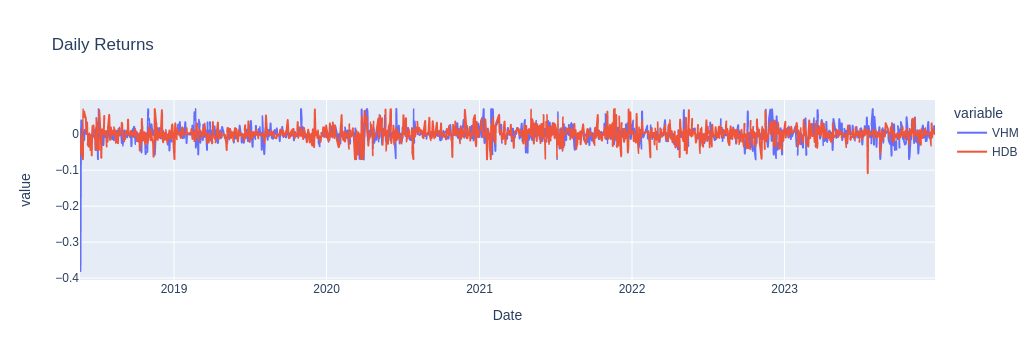

In [14]:
fig = px.line(daily_returns[['VHM', 'HDB']], title='Daily Returns')
fig.show()

## Volatility

#### Daily Volatility

Daily Volatility is the average difference between the return on a given day and the average return over the time period. Mathematically, it is just the standard deviation of the daily returns. Volatility is one of the measures of risk in that highly volatile investments can carry greater risk.

In [14]:
daily_returns.std()

AMZN    0.019330
BA      0.023948
JPM     0.016772
MA      0.017019
META    0.022239
V       0.015621
dtype: float64

Here we see that BA has a slightly higher volatility, compared to that of V. When we compare the density plots of their daily returns, we can see that V has a narrower curve with a higher peak, while BA has a wider curve indicating higher standard deviation and hence volatility.

/home/son/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



(-0.1, 0.1)

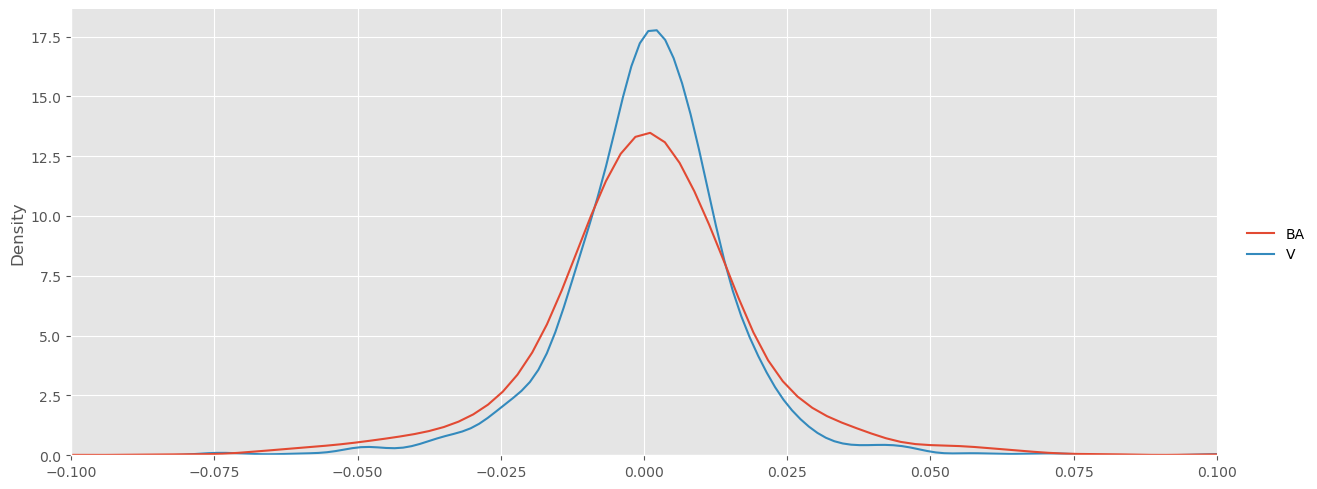

In [15]:
sns.displot(data=daily_returns[['BA', 'V']], kind = 'kde', aspect = 2.5)
plt.xlim(-0.1, 0.1)

#### Annual Volatility

For completeness, the Annual Volatility is a more common measure can be calculated simply by multiply the daily volatility by the square root of the number of trading days in a year i.e. 252. 

## Plot Individual Cumulative Returns
The cumulative returns of the stock can be easily calculated by adding one to the daily returns and taking the cumulative product over the whole period. Here we plot the cumulative returns of stocks starting with an initial investment of 100 (how much would investing 100 at the start in each individual stock get you over the time period?) This is a fair comparison for the performance of the stocks.

/home/son/anaconda3/lib/python3.11/site-packages/_plotly_utils/basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



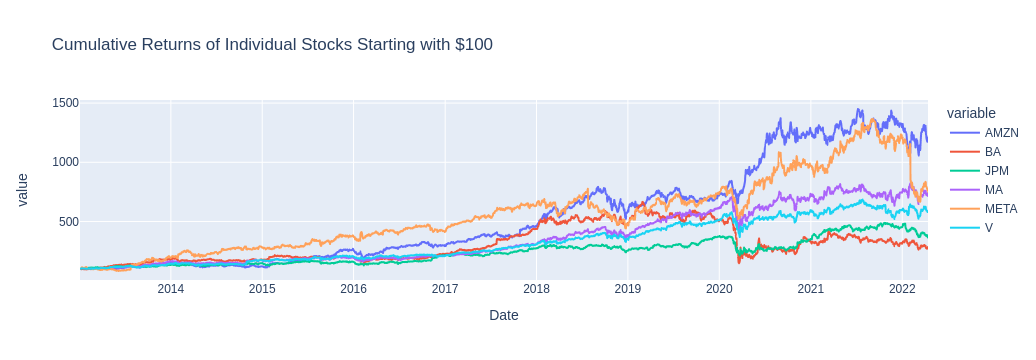

In [16]:
def plot_cum_returns(data, title):    
    daily_cum_returns = (1 + daily_returns).cumprod()*100
    fig = px.line(daily_cum_returns, title=title)
    return fig
    
fig_cum_returns = plot_cum_returns(stocks_df, 'Cumulative Returns of Individual Stocks Starting with $100')
fig_cum_returns.show()

## Plot Correlation Matrix between Stocks
The correlation matrix gives us the correlation coefficients between every pair of stocks. Correlation coefficients are indicators of the strength of the linear relationship between two different variables. It is a value from 0 to 1, with 1 indicating the strongest relationship. If it is a negative value, then the two variables are inversely related. 

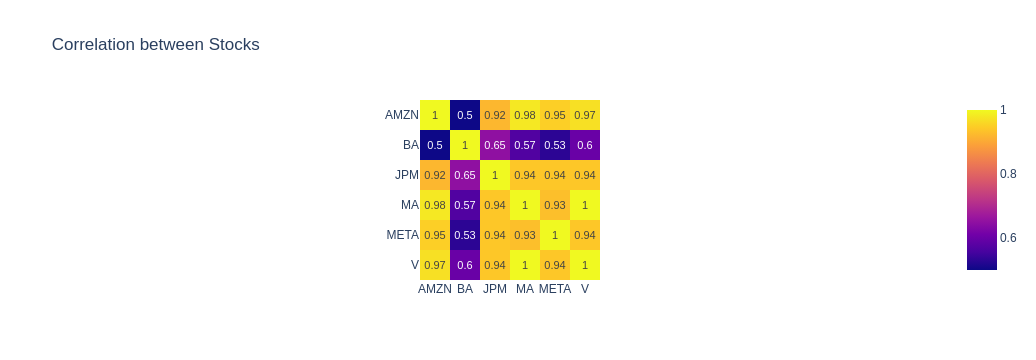

In [17]:
corr_df = stocks_df.corr().round(2) # round to 2 decimal places
fig_corr = px.imshow(corr_df, text_auto=True, title = 'Correlation between Stocks')
fig_corr.show()


In general (though not always), stock prices tend to move together (increase in bull market, decrease in bear market), hence the correlation would most likely be positive as shown below. Also notice how Boeing (BA) is weakly correlated to other stocks during this time period. This may be because it is in a very different industry, or because of the bad news that has been hitting it over the recent years. And notice how Mastercard (MA) and Visa (V) are almost perfectly correlated.

## Get Expected Returns and Covariance Matrix
Similarly, the covariance matrix measures whether stocks move in the same direction (a positive covariance) or in opposite directions (a negative covariance). 
It is used to calculate the volatility of the whole portfolio of stocks, which in turn is used by portfolio managers to quantify its risk. PyPortfolioOpt makes it easy to get this matrix, and also the mean annual return of each stocks. We need these as inputs to find our optimized portfolio later.

In [21]:
stocks_df

AMZN          BA         JPM          MA        META  \
Date                                                                     
2013-01-02   12.865500   64.583847   33.084866   47.807560   28.000000   
2013-01-03   12.924000   64.919037   33.018196   47.875954   27.770000   
2013-01-04   12.957500   65.103409   33.603455   47.874092   28.760000   
2013-01-07   13.423000   63.796131   33.640484   48.703743   29.420000   
2013-01-08   13.319000   62.120155   33.707157   48.543438   29.059999   
...                ...         ...         ...         ...         ...   
2022-04-08  154.460495  175.199997  127.350121  349.034668  222.330002   
2022-04-11  151.121994  175.029999  126.882629  344.179688  216.460007   
2022-04-12  150.787506  176.279999  125.489777  342.624115  214.139999   
2022-04-13  155.541000  182.869995  121.444801  351.878418  214.990005   
2022-04-14  151.706497  181.940002  120.319077  354.533722  210.179993   

                     V  
Date                    
2013-01-02   35.941444  
2013-01-03   35.969185  
2013-01-04   36.262966  
2013-01-07   36.522041  
2013-01-08   36.862072  
...                ...  
2022-04-08  214.001953  
2022-04-11  211.802536  
2022-04-12  208.498520  
2022-04-13  210.342850  
2022-04-14  209.869431  

[2339 rows x 6 columns]

In [19]:
# Calculate expected returns and sample covariance matrix
mu = expected_returns.mean_historical_return(stocks_df)
S = risk_models.sample_cov(stocks_df)

print(mu)

AMZN    0.304666
BA      0.118103
JPM     0.149305
MA      0.241052
META    0.242676
V       0.209486
dtype: float64


## Optimize portfolio for max Sharpe ratio plot it out with efficient frontier curve
The efficient frontier is the set of optimal portfolios that offer the highest expected return for a defined level of risk (volatility) or the lowest risk (volatility) for a given level of expected return. It is represented by a line on a Return vs Volatility graph. The max Sharpe ratio portfolio lies on the efficient frontier. 

To represent everything visually, the code below (from documentation) generates 1000 portfolios of our stocks with random weights and plot out their returns and volatility. The efficient frontier and the max Sharpe ratio portfolio is also plotted on the graph.

/home/son/anaconda3/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning:


    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    



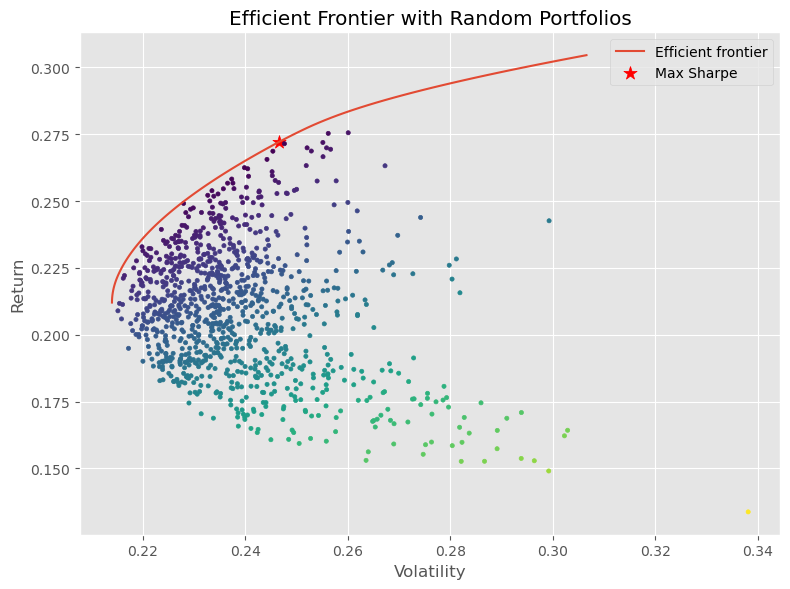

In [22]:
def plot_efficient_frontier_and_max_sharpe(mu, S):  
    # Optimize portfolio for maximal Sharpe ratio 
    ef = EfficientFrontier(mu, S)

    fig, ax = plt.subplots(figsize=(8,6))
    ef_max_sharpe = copy.deepcopy(ef)
    plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)

    # Find the max sharpe portfolio
    ef_max_sharpe.max_sharpe(risk_free_rate=0.02)
    ret_tangent, std_tangent, _ = ef_max_sharpe.portfolio_performance()
    ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

    # Generate random portfolios
    n_samples = 1000
    w = np.random.dirichlet(np.ones(ef.n_assets), n_samples)
    rets = w.dot(ef.expected_returns)
    stds = np.sqrt(np.diag(w @ ef.cov_matrix @ w.T))
    sharpes = rets / stds
    ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

    # Output
    ax.set_title("Efficient Frontier with Random Portfolios")
    ax.legend()
    plt.tight_layout()
    plt.show()
    
plot_efficient_frontier_and_max_sharpe(mu, S)

Hopefully the graph gives you a better idea of what the efficient frontier is. In the graph above, we see that the efficient frontier is like a boundary. i.e. It is not possible for portfolios to lie above the frontier (else we would have portfolios with the same volatility as those on the frontier but with higher expected returns). It is also not possible for portfolios to lie at the left of the frontier (else we would have portfolios with the same expected returns as those on the frontier but with lower volatility).

## Get Weights for Optimized Portfolio

In [23]:
ef = EfficientFrontier(mu, S)
ef.max_sharpe(risk_free_rate=0.02)
weights = ef.clean_weights()
print(weights)

OrderedDict([('AMZN', 0.52723), ('BA', 0.0), ('JPM', 0.0), ('MA', 0.35912), ('META', 0.03502), ('V', 0.07864)])


In [24]:
weights_df = pd.DataFrame.from_dict(weights, orient = 'index')
weights_df.columns = ['weights']
weights_df

weights
AMZN  0.52723
BA    0.00000
JPM   0.00000
MA    0.35912
META  0.03502
V     0.07864

Notice how certain weights tend to dominate by high performing stocks (high returns with relatively ok volatility), while some weights tend to be 0. One of the weakness of the max Sharpe portfolio optimization approach is that the portfolio may not be as diversified (across types of stocks or industries) as we want it to be. Also, as cliche as it may sound, past performance is not indicative of future results. We are obtaining the expected returns and volatility based on the movement of stock prices in the past, the future returns/volatility may very well differ.

## Expected Annual Return, Annual Volatility and Sharpe Ratio for Optimized Portfolio

In [16]:
expected_annual_return, annual_volatility, sharpe_ratio = ef.portfolio_performance()

print('Expected annual return: {}%'.format((expected_annual_return*100).round(2)))
print('Annual volatility: {}%'.format((annual_volatility*100).round(2)))
print('Sharpe ratio: {}'.format(sharpe_ratio.round(2)))

Expected annual return: 27.22%
Annual volatility: 24.67%
Sharpe ratio: 1.02


## Generate Portfolio with Optimized Weights

In [17]:
stocks_df['Optimized Portfolio'] = 0

for ticker, weight in weights.items():
    stocks_df['Optimized Portfolio'] += stocks_df[ticker]*weight

stocks_df.head()

AMZN         BA        JPM         MA       META          V  \
Date                                                                         
2013-01-02  12.8655  64.583839  33.328999  47.876865  28.000000  36.085693   
2013-01-03  12.9240  64.919044  33.261829  47.945343  27.770000  36.113556   
2013-01-04  12.9575  65.103416  33.851391  47.943481  28.760000  36.408520   
2013-01-07  13.4230  63.796139  33.888706  48.774345  29.420000  36.668625   
2013-01-08  13.3190  62.120159  33.955879  48.613804  29.059999  37.010014   

            Optimized Portfolio  
Date                             
2013-01-02            27.794478  
2013-01-03            27.844048  
2013-01-04            27.918908  
2013-01-07            28.506273  
2013-01-08            28.408028

## Plot Cumulative Returns of Optimized Portfolio

In [18]:
fig_cum_returns_optimized = plot_cum_returns(stocks_df['Optimized Portfolio'], 'Cumulative Returns of Optimized Portfolio Starting with $100')
fig_cum_returns_optimized.show()